### Importing function and setting up dirs

In [236]:
import os
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, color_fa
import dipy.reconst.dti as dti
import h5py

In [2]:
base_dir = "/storage"
base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in os.listdir(base_dir + "/HCP_7T") if len(i) == 6]
base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in os.listdir(base_dir + "/HCP_3T") if len(i) == 6]

path_7t = {}
path_3t = {}



for i in base_dir_7t:
    path_7t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.05.nii.gz" ,"data" : i + "/T1w/Diffusion_7T/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion_7T/bvals" , "bvecs" : i + "/T1w/Diffusion_7T/bvecs"
                      , "brain_mask" : i + "/T1w/Diffusion_7T/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion_7T/grad_dev.nii.gz"}
for i in base_dir_3t:
    path_3t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.25.nii.gz" , "data" : i + "/T1w/Diffusion/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion/bvals" , "bvecs" : i + "/T1w/Diffusion/bvecs"
                       , "brain_mask" : i + "/T1w/Diffusion/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion/grad_dev.nii.gz"}
    
    
path = {'3T': path_3t, "7T": path_7t}
p = list(path_7t.keys())
q = list(path_3t.keys())
common = list(set(p) & set(q))
common.sort()
print("number of common Subjects ",len(common))

number of common Subjects  171


In [10]:
path_3t[common[0]]

{'3d_scan': '/storage/HCP_3T/100610/T1w/T1w_acpc_dc_restore_1.25.nii.gz',
 'data': '/storage/HCP_3T/100610/T1w/Diffusion/data.nii.gz',
 'bvals': '/storage/HCP_3T/100610/T1w/Diffusion/bvals',
 'bvecs': '/storage/HCP_3T/100610/T1w/Diffusion/bvecs',
 'brain_mask': '/storage/HCP_3T/100610/T1w/Diffusion/nodif_brain_mask.nii.gz',
 'grad_dev': '/storage/HCP_3T/100610/T1w/Diffusion/grad_dev.nii.gz'}

In [5]:
# for i in common:
#     name = "/storage/HCP_7T/" + i + "/" + i + "_GT.h5"
#     print(i,os.path.isfile(name))

### Functions to read the files in nifty

In [11]:
def get_ids():
    return common

def load_hcp(id_load,res):
    
    load_from = path[res][id_load]
    
    data,affine = load_nifti(load_from["data"])
    
    mask,affine = load_nifti(load_from["brain_mask"])
    
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    
    gtab = gradient_table(bvals, bvecs)
    
    return data,mask,gtab

def load_gtab(id_load,res):
    load_from = path[res][id_load]
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    gtab = gradient_table(bvals, bvecs)
    return gtab

### Referred from DeepDTI paper

In [276]:
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy.linalg import inv
from numpy.linalg import pinv
# from numpy.linalg import lstsq
from scipy.linalg import lstsq
from numpy.linalg import solve
from numpy import inf
import numpy as np

import SimpleITK as sitk


dsm = np.array([0.91, 0.416, 0,0, 0.91, 0.416,0.416, 0, 0.91,0.91, -0.416, 0,0, 0.91, -0.416,-0.416, 0, 0.91])
dsm = dsm.reshape(6,3)
dsm_norm = np.copy(dsm)
dsm_mag = np.sqrt(dsm[:,0]**2 + dsm[:,1]**2 + dsm[:,2]**2)
for i in range(3):
    dsm_norm[:,i] = dsm[:,i] / dsm_mag

def rot3d(arg):
    x,y,z = arg[0],arg[1],arg[2]
    Rx = np.array([[1 ,0 ,0 ],[0,np.cos(x),-np.sin(x)],[0 ,np.sin(x) ,np.cos(x)]])
    Ry = np.array([[np.cos(y),0 ,np.sin(y) ],[0,1,0],[-np.sin(y),0,np.cos(y)]])
    Rz = np.array([[np.cos(z) ,-np.sin(z) ,0 ],[np.sin(z),np.cos(z),0],[0 ,0,1]])
    R = Rx @ Ry @ Rz
    return R

def amatrix(mat):
    
    a = [mat[:,0] * mat[:,0],2 * mat[:,0] * mat[:,1], 2* mat[:,0] * mat[:,2],
        mat[:,1] * mat[:,1],2 * mat[:,1] * mat[:,2], mat[:,2] * mat[:,2]]
    return np.array(a).T

def optimal_dirs(gtab,num_iter,num_dirs,debug = False,base_bval = 5):
    rotang_all = []
    angerr_all  = []
    condnum_all = []
    ind_all = []
    dirs = np.array(gtab.bvecs[np.where(gtab.bvals != base_bval)[0]])
    for i in range(0,num_iter):
        
        d = np.random.rand(1,3) * 2 * np.pi
        rotang = d[0]
        R = rot3d(rotang)
        dsm_rot = (rot3d(d[0]) @ dsm_norm.T).T
        
        ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))
        minerrors,idx = np.amin(ang_error,1),np.argmin(ang_error,1)

        mean_ang_err = np.mean(np.amin(ang_error,1))
        condnum = np.linalg.cond(amatrix(dirs[idx]))
        
        idx.sort()
        if (mean_ang_err < 5 and condnum < 1.6):
            if ((len(ind_all) == 0 ) or  len(np.where((ind_all == idx).all(axis=1))[0]) == 0 ):
                angerr_all.append(mean_ang_err)
                condnum_all.append(condnum)
                ind_all.append(idx)
                rotang_all.append(rotang)
    condnum_all = np.array(condnum_all)
    indx  = condnum_all.argsort()[:num_dirs]
    if (debug):
        print("Lowest Condition Number : ",condnum_all[indx])
    ind_use = np.array(ind_all)[indx]
    condnum_use = condnum_all[condnum_all.argsort()[:5]]
    angerr_use = np.array(angerr_all)[indx]
    rotang_use = np.array(rotang_all)[indx]
    return ind_use,condnum_all[indx]

# import numpy as np


# def resample_img(itk_image, out_spacing,sampler = 'bspline'):
    
#     original_spacing = itk_image.GetSpacing()

#     original_size = itk_image.GetSize()

#     out_size = [
#         int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
#         int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
#         int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

#     resample = sitk.ResampleImageFilter()
#     resample.SetOutputSpacing(out_spacing)
#     resample.SetSize(out_size)
#     resample.SetOutputDirection(itk_image.GetDirection())
#     resample.SetOutputOrigin(itk_image.GetOrigin())
#     resample.SetTransform(sitk.Transform())
#     resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

#     if sampler == 'bspline':
#         resample.SetInterpolator(sitk.sitkBSpline)
#     elif sampler == 'nearneighbour':
#         resample.SetInterpolator(sitk.sitkNearestNeighbor)
#     else:
#         resample.SetInterpolator(sitk.sitkLinear)

#     return resample.Execute(itk_image)

def resampler(data_sitk,idx,b0):
    resampled_sitk_img = []
#     if(upscale == True):
#         resampled_img = resample_img(data_sitk[:,:,:,int(b0)], out_spacing=[1.05,1.05, 1.05],sampler = 'linear')
#         resampled_sitk_img.append(sitk.GetArrayFromImage(resampled_img))
#         for i in idx:
#             resampled_img = resample_img(data_sitk[:,:,:,int(i)], out_spacing=[1.05,1.05, 1.05],sampler = 'linear')
#             resampled_sitk_img.append(sitk.GetArrayFromImage(resampled_img))
#     else:
    resampled_sitk_img.append(sitk.GetArrayFromImage(data_sitk[:,:,:,int(b0)]))
    for i in idx:
        resampled_sitk_img.append(sitk.GetArrayFromImage(data_sitk[:,:,:,int(i)]))
    data_temp = np.stack(resampled_sitk_img, axis=3)
    maskdata, mask = median_otsu(data_temp, vol_idx=range(0, data_temp.shape[-1]),autocrop=True, dilate=2)
    maskdata = norm(np.transpose(maskdata, (2,1,0,3)))
#     mask = norm(np.transpose(mask, (2,1,0)))
    return maskdata,mask


In [175]:
limited_common = common[:40]

In [171]:
len(limited_common)

40

In [172]:
limited_common

['100610',
 '102311',
 '102816',
 '104416',
 '105923',
 '108323',
 '109123',
 '111312',
 '111514',
 '114823',
 '115017',
 '115825',
 '116726',
 '118225',
 '125525',
 '126426',
 '128935',
 '130114',
 '130518',
 '131722',
 '132118',
 '134627',
 '134829',
 '135124',
 '137128',
 '140117',
 '144226',
 '145834',
 '146129',
 '146432',
 '146735',
 '146937',
 '148133',
 '155938',
 '156334',
 '157336',
 '158035',
 '158136',
 '159239',
 '162935']

### Normalization 

In [332]:

import torchio as tio
    
def norm(data,type=None):
    if(type=="ZNorm"):
        transform = tio.ZNormalization()
        return transform(data)
    return ((data-np.min(data))/(np.max(data)-np.min(data)))

In [79]:
curr_id = '100610'

In [113]:
data_sitk = sitk.ReadImage(path['3T'][curr_id]['data'])

In [114]:
data,mask,gtab = load_hcp(curr_id,'3T')

In [152]:
data_7t,mask_7t,gtab = load_hcp(curr_id,'7T')

In [148]:
data6 = resampler(data_sitk,[1,2,3,4,5],0)
data6 = np.transpose(data6, (2,1,0,3))


In [116]:
maskdata, mask = median_otsu(data, vol_idx=range(0, data.shape[-1]),autocrop=True, dilate=2)

In [149]:
maskdata6, mask6 = median_otsu(data6, vol_idx=range(0, data6.shape[-1]),autocrop=True, dilate=2)

In [153]:
maskdata_hr, mask_hr = median_otsu(data_7t, vol_idx=range(0, data_7t.shape[-1]),autocrop=True, dilate=2)

In [117]:
data.shape,data6.shape

((145, 174, 145, 288), (145, 174, 145, 6))

In [156]:
maskdata.shape,data.shape

((113, 147, 107, 288), (145, 174, 145, 288))

In [155]:
maskdata_hr.shape,data_7t.shape

((133, 177, 113, 143), (173, 207, 173, 143))

In [91]:
histogram

array([21259505,   550580,    97126,    27970,     8840,     3128,
           1727,      836,      339,       49])

In [111]:
histogram

array([1041997795,    9614409,    1426913,     382008,     108314,
            44669,      21336,       7893,       1425,         38])

In [96]:
bin_edges

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32)

In [123]:
data = norm(data)
data6 = norm(data6)
data_masked = norm(maskdata)

In [127]:
hist,bins = {},{}
hist['hr'],bins['hr'] = np.histogram(data)
hist['hr6'],bins['hr6'] = np.histogram(data6)
hist['hrm'],bins['hrm'] = np.histogram(data_masked)

In [129]:
hist,bins

({'hr': array([1041914684,    9686290,    1434041,     385621,     108803,
              44669,      21336,       7893,       1425,         38]),
  'hr6': array([21259505,   550580,    97126,    27970,     8840,     3128,
             1727,      836,      339,       49]),
  'hr6_mask': array([500277571,   9614409,   1426913,    382008,    108314,     44669,
             21336,      7893,      1425,        38])},
 {'hr': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
        dtype=float32),
  'hr6': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
        dtype=float32),
  'hr6_mask': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
        dtype=float32)})

In [134]:
len(hist['hr'])

10

In [136]:
len(bins['hr'])

11

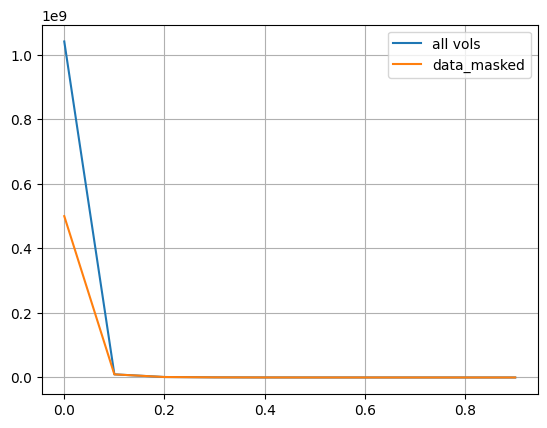

In [139]:
%matplotlib inline

plt.plot(bins['hr'][:-1], hist['hr'],label="all vols")

# plt.plot(bins['hr6'][1:-1], hist['hr6'][1:],label="6 vols")

plt.plot(bins['hr6_mask'][:-1], hist['hr6_mask'],label="data_masked")

# plt.yscale("log")
plt.legend()
plt.grid()

## 3T dump

In [222]:
shape_file = {}
shape_file_7t = {}

In [ ]:
for i in limited_common:
    name = "/storage/HCP_3T/" + i + "/" + i + ".h5"
    if(not os.path.isfile(name) or True):
        print("Current ID",i)

        gtab = load_gtab(i,'3T')

        data_sitk = sitk.ReadImage(path['3T'][i]['data'])
        mask_sitk = sitk.ReadImage(path['3T'][i]['brain_mask'])
        hf = h5py.File(name, 'w')
        
        idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))

        idx = np.where(gtab.bvals>int(min(gtab.bvals)))[0][idx]

        for j in range(1):
            sample = np.random.randint(0,len(np.where(gtab.bvals==int(min(gtab.bvals)))[0]))
            ## picking one base bval volume randomly from the data
            sample = np.where(gtab.bvals==int(min(gtab.bvals)))[0][sample]
            
            ## picking the bvals,bvecs and corresponding vols from the data 
            bvals6 = np.insert(gtab.bvals[idx[j]],0,gtab.bvals[sample])
            bvecs6 = np.insert(gtab.bvecs[idx[j]],0,gtab.bvecs[sample],axis = 0)
            data6,mask6 = resampler(data_sitk,idx[j],sample)
            shape_file[i] = (data6.shape)
            hf.create_dataset('volumes'+ str(j), data=data6)
            hf.create_dataset('bvals'+ str(j), data=bvals6)
            hf.create_dataset('bvecs'+ str(j), data=bvecs6)

        hf.create_dataset('idx', data=idx)
        hf.create_dataset('cond', data=cond)
        mask = mask_sitk
        hf.create_dataset('mask', data=np.transpose(sitk.GetArrayFromImage(mask), (2,1,0)))

        hf.close()

        print(name,"Done")

        

Current ID 100610


/tmp/ipykernel_16861/3433370057.py:53: RuntimeWarning: invalid value encountered in arccos
  ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))


Lowest Condition Number :  [1.41846062 1.42238217 1.42797114 1.44724113 1.45105456]
/storage/HCP_3T/100610/100610.h5 Done
Current ID 102311
Lowest Condition Number :  [1.4100451  1.42013738 1.43240749 1.43492422 1.44124793]
/storage/HCP_3T/102311/102311.h5 Done
Current ID 102816
Lowest Condition Number :  [1.42877526 1.443289   1.44999138 1.4545913  1.45652504]


In [ ]:
hf.close()

## Code for preprocessing at 3T

In [26]:

#     data,mask,gtab = load_hcp(i,'3T')
#     name = "/storage/HCP_3T/" + i + "/" + i + "_GT.h5"
#     hf = h5py.File(name, 'w')
    
#     tenmodel = dti.TensorModel(gtab)
#     maskdata, mask = median_otsu(data, vol_idx=range(0, data.shape[-1]),autocrop=False, dilate=2)
#     tenfit = tenmodel.fit(data,mask=mask)
#     tensor_vals = dti.lower_triangular(tenfit.quadratic_form)
#     FA = fractional_anisotropy(tenfit.evals)
#     MD = dti.mean_diffusivity(tenfit.evals)
#     FA[np.isnan(FA)] = 0
#     FA = np.clip(FA, 0, 1)
#     RGB = color_fa(FA, tenfit.evecs)
    
#     hf.create_dataset('tensor_vals', data=tensor_vals)
#     hf.create_dataset('ADC', data=MD)
#     hf.create_dataset('FA', data=FA)
#     hf.create_dataset('color_FA', data=RGB)
    
#     hf.close()
#     print(name,"Done")

### 7T dump

In [ ]:
for i in limited_common:
    name = "/storage/HCP_7T/" + i + "/" + i + ".h5"
    if(not os.path.isfile(name) or True):
        print("Current ID",i)

        gtab = load_gtab(i,'7T')

        data_sitk = sitk.ReadImage(path['7T'][i]['data'])
        mask_sitk = sitk.ReadImage(path['7T'][i]['brain_mask'])
        hf = h5py.File(name, 'w')

        idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))

        idx = np.where(gtab.bvals>int(min(gtab.bvals)))[0][idx]

        for j in range(1):
            sample = np.random.randint(0,len(np.where(gtab.bvals==int(min(gtab.bvals)))[0]))
            sample = np.where(gtab.bvals==int(min(gtab.bvals)))[0][sample]

            bvals6 = np.insert(gtab.bvals[idx[j]],0,gtab.bvals[sample])
            bvecs6 = np.insert(gtab.bvecs[idx[j]],0,gtab.bvecs[sample],axis = 0)
            data6,mask6 = resampler(data_sitk,idx[j],sample)
            shape_file_7t[i] = (data6.shape)
            hf.create_dataset('volumes'+ str(j), data=data6)
            hf.create_dataset('bvals'+ str(j), data=bvals6)
            hf.create_dataset('bvecs'+ str(j), data=bvecs6)

        hf.create_dataset('idx', data=idx)
        hf.create_dataset('cond', data=cond)
        mask = mask_sitk
        hf.create_dataset('mask', data=np.transpose(sitk.GetArrayFromImage(mask), (2,1,0)))

        hf.close()

        print(name,"Done")


## Code for preprocessing at 7T

In [194]:
for i in limited_common:
    name = "/storage/HCP_7T/" + i + "/" + i + "_GT.h5"
    if(not os.path.isfile(name) or True):
        print("Current ID",i)
        data,mask,gtab = load_hcp(i,'7T')
        hf = h5py.File(name, 'w')
        
        tenmodel = dti.TensorModel(gtab)
        maskdata, mask = median_otsu(data, vol_idx=range(0, data.shape[-1]),autocrop=True, dilate=2)
        maskdata = norm(maskdata)
#         mask = norm(mask)
        tenfit = tenmodel.fit(maskdata,mask=mask)
        tensor_vals = dti.lower_triangular(tenfit.quadratic_form)
        FA = fractional_anisotropy(tenfit.evals)
        MD = dti.mean_diffusivity(tenfit.evals)
        FA[np.isnan(FA)] = 0
        FA = np.clip(FA, 0, 1)
        RGB = color_fa(FA, tenfit.evecs)

        hf.create_dataset('tensor_vals', data=tensor_vals)
        hf.create_dataset('ADC', data=MD)
        hf.create_dataset('FA', data=FA)
        hf.create_dataset('color_FA', data=RGB)

        hf.close()
        print(name,"Done")

Current ID 100610
/storage/HCP_7T/100610/100610_GT.h5 Done
Current ID 102311
/storage/HCP_7T/102311/102311_GT.h5 Done
Current ID 102816
/storage/HCP_7T/102816/102816_GT.h5 Done
Current ID 104416
/storage/HCP_7T/104416/104416_GT.h5 Done
Current ID 105923
/storage/HCP_7T/105923/105923_GT.h5 Done
Current ID 108323
/storage/HCP_7T/108323/108323_GT.h5 Done
Current ID 109123
/storage/HCP_7T/109123/109123_GT.h5 Done
Current ID 111312
/storage/HCP_7T/111312/111312_GT.h5 Done
Current ID 111514
/storage/HCP_7T/111514/111514_GT.h5 Done
Current ID 114823
/storage/HCP_7T/114823/114823_GT.h5 Done
Current ID 115017
/storage/HCP_7T/115017/115017_GT.h5 Done
Current ID 115825
/storage/HCP_7T/115825/115825_GT.h5 Done
Current ID 116726
/storage/HCP_7T/116726/116726_GT.h5 Done
Current ID 118225
/storage/HCP_7T/118225/118225_GT.h5 Done
Current ID 125525
/storage/HCP_7T/125525/125525_GT.h5 Done
Current ID 126426
/storage/HCP_7T/126426/126426_GT.h5 Done
Current ID 128935
/storage/HCP_7T/128935/128935_GT.h5 Do

In [193]:
hf.close()

In [44]:
i

'971160'

In [188]:
%who

FA	 MD	 RGB	 amatrix	 base_dir	 base_dir_3t	 base_dir_7t	 bin_edges	 bins	 
bvals6	 bvecs6	 color_fa	 common	 cond	 curr_id	 data	 data6	 data_7t	 
data_masked	 data_sitk	 dsm	 dsm_mag	 dsm_norm	 dti	 eig	 fractional_anisotropy	 get_ids	 
gradient_table	 gtab	 h5py	 hf	 hist	 histogram	 hr	 i	 idx	 
inf	 inv	 j	 limited_common	 load_gtab	 load_hcp	 load_nifti	 lstsq	 mask	 
mask6	 mask_7t	 mask_hr	 mask_sitk	 maskdata	 maskdata6	 maskdata_hr	 median_otsu	 name	 
norm	 np	 optimal_dirs	 os	 p	 path	 path_3t	 path_7t	 pinv	 
plt	 q	 read_bvals_bvecs	 resampler	 rot3d	 sample	 shape_file	 shape_file_7t	 sitk	 
solve	 tenfit	 tenmodel	 tensor_vals	 


In [240]:
temp=[]
for i in limited_common:
    temp.append([shape_file[i][j]/shape_file_7t[i][j] for j in range(3)])

array([0.84962406, 0.83076923, 0.8515625 , 0.84677419, 0.83458647,
       0.84615385, 0.84615385, 0.85123967, 0.84444444, 0.84251969,
       0.82442748, 0.84920635, 0.84251969, 0.85606061, 0.85365854,
       0.83471074, 0.85483871, 0.82191781, 0.85123967, 0.84375   ,
       0.84328358, 0.84920635, 0.84126984, 0.82945736, 0.85470085,
       0.84920635, 0.8442623 , 0.83333333, 0.84444444, 0.84496124,
       0.82786885, 0.83739837, 0.83333333, 0.84444444, 0.84558824,
       0.8559322 , 0.84677419, 0.8487395 , 0.84126984, 0.84671533])

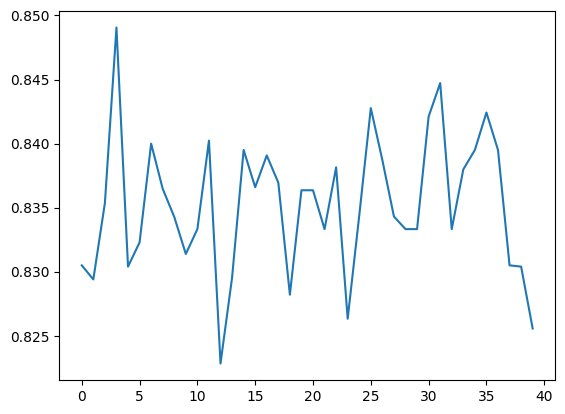

In [258]:
# plt.plot(range(len(temp)),np.array(temp)[:,0])
plt.plot(range(len(temp)),np.array(temp)[:,1])
# plt.plot(range(len(temp)),np.array(temp)[:,2])

In [213]:
# temp

[[0.849624060150376, 0.8305084745762712, 0.9469026548672567],
 [0.84375, 0.8294117647058824, 0.8360655737704918],
 [0.8515625, 0.8303030303030303, 0.84375],
 [0.8467741935483871, 0.8490566037735849, 0.8333333333333334],
 [0.8345864661654135, 0.8352941176470589, 0.8384615384615385],
 [0.8461538461538461, 0.8322981366459627, 0.7938931297709924],
 [0.8461538461538461, 0.8342857142857143, 0.8201438848920863],
 [0.8512396694214877, 0.8364779874213837, 0.8225806451612904],
 [0.8582089552238806, 0.8342857142857143, 0.8484848484848485],
 [0.84251968503937, 0.8362573099415205, 0.856],
 [0.8181818181818182, 0.8333333333333334, 0.8560606060606061],
 [0.8492063492063492, 0.8402366863905325, 0.9186991869918699],
 [0.84251968503937, 0.8285714285714286, 0.8333333333333334],
 [0.8636363636363636, 0.84, 1.0],
 [0.8617886178861789, 0.8395061728395061, 0.8372093023255814],
 [0.8333333333333334, 0.8366013071895425, 0.8888888888888888],
 [0.8548387096774194, 0.8333333333333334, 0.8455284552845529],
 [0.821

In [206]:
len(shape_file_7t)

40

In [15]:
import os
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, color_fa
import dipy.reconst.dti as dti
import h5py
import matplotlib.pyplot as plt

In [203]:
for i in limited_common:
    name = "/storage/HCP_7T/" + i + "/" + i + "_GT.h5"
    hf = h5py.File(name, 'r')
    shape_file_7t[i] = np.array(hf.get("ADC")).shape

In [259]:
name = "/storage/HCP_7T/" + common[0] + "/" + common[0] + "_GT.h5"
hf = h5py.File(name, 'r')
name = "/storage/HCP_3T/" + common[0] + "/" + common[0] + ".h5"
hf_lr = h5py.File(name, 'r')

In [317]:
name

'/storage/HCP_3T/100610/100610.h5'

In [261]:
import numpy as np

In [262]:
for i in list(hf_lr.keys()):
    print(i,np.array(hf_lr.get(i)).shape)

bvals0 (7,)
bvecs0 (7, 3)
cond (5,)
idx (5, 6)
mask (145, 174, 145)
volumes0 (113, 147, 107, 7)


In [263]:
for i in list(hf.keys()):
    print(i,np.array(hf.get(i)).shape)

ADC (133, 177, 113)
FA (133, 177, 113)
color_FA (133, 177, 113, 3)
tensor_vals (133, 177, 113, 6)


In [298]:
import torchio as tio
transform = tio.transforms.RescaleIntensity(percentiles=(2,98))

In [330]:
%matplotlib inline
hist,bins = {},{}
# hist['lr'],bins['lr'] = np.histogram(norm(np.array(hf_lr.get('volumes0'))))
hist['lr_n'],bins['lr_n'] = np.histogram(transform(np.array(hf_lr.get('volumes0'))))
hist['md'],bins['md'] = np.histogram(transform(np.expand_dims(np.array(hf.get("ADC")),axis=0)))
# hist['adc'],bins['adc'] = np.histogram(transform(np.expand_dims(MD,axis=0)))

hist['fa'],bins['fa'] = np.histogram(norm(np.array(hf.get("FA"))))
hist['rgb'],bins['rgb'] = np.histogram(norm(np.array(hf.get("color_FA"))))


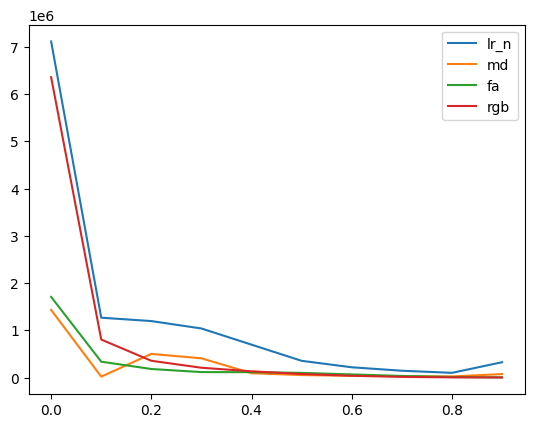

In [331]:
for i in hist.keys():
    plt.plot(bins[i][:-1],hist[i],label=i)
plt.legend()

In [ ]:
plt.plot(bins['hr'][:-1], hist['hr'],label="all vols")

# plt.plot(bins['hr6'][1:-1], hist['hr6'][1:],label="6 vols")

plt.plot(bins['hr6_mask'][:-1], hist['hr6_mask'],label="data_masked")

# plt.yscale("log")
plt.legend()
plt.grid()

In [34]:
np.array(hf.get('idx'))

array(None, dtype=object)

In [35]:
np.array(hf.get('bvals0'))

array(None, dtype=object)

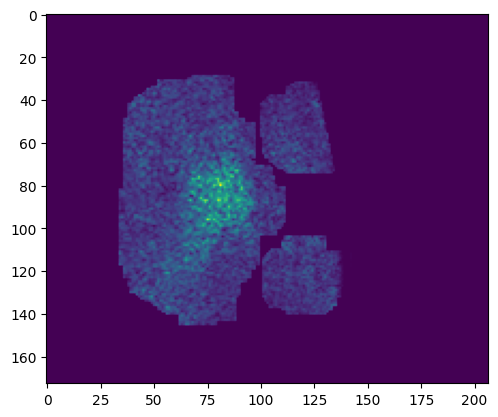

In [23]:
plt.imshow(np.array(hf.get('volumes0'))[:,:,20,6])

In [24]:
for i in list(hf_lr.keys()):
    print(i,np.array(hf_lr.get(i)).shape)

bvals0 (7,)
bvals1 (7,)
bvals2 (7,)
bvecs0 (7, 3)
bvecs1 (7, 3)
bvecs2 (7, 3)
cond (5,)
idx (5, 6)
mask (145, 174, 145)
volumes0 (145, 174, 145, 7)
volumes1 (145, 174, 145, 7)
volumes2 (145, 174, 145, 7)


In [25]:
np.array(hf_lr.get('bvals0'))

array([   5.,  990., 1000., 1005., 1000., 2985., 1995.])

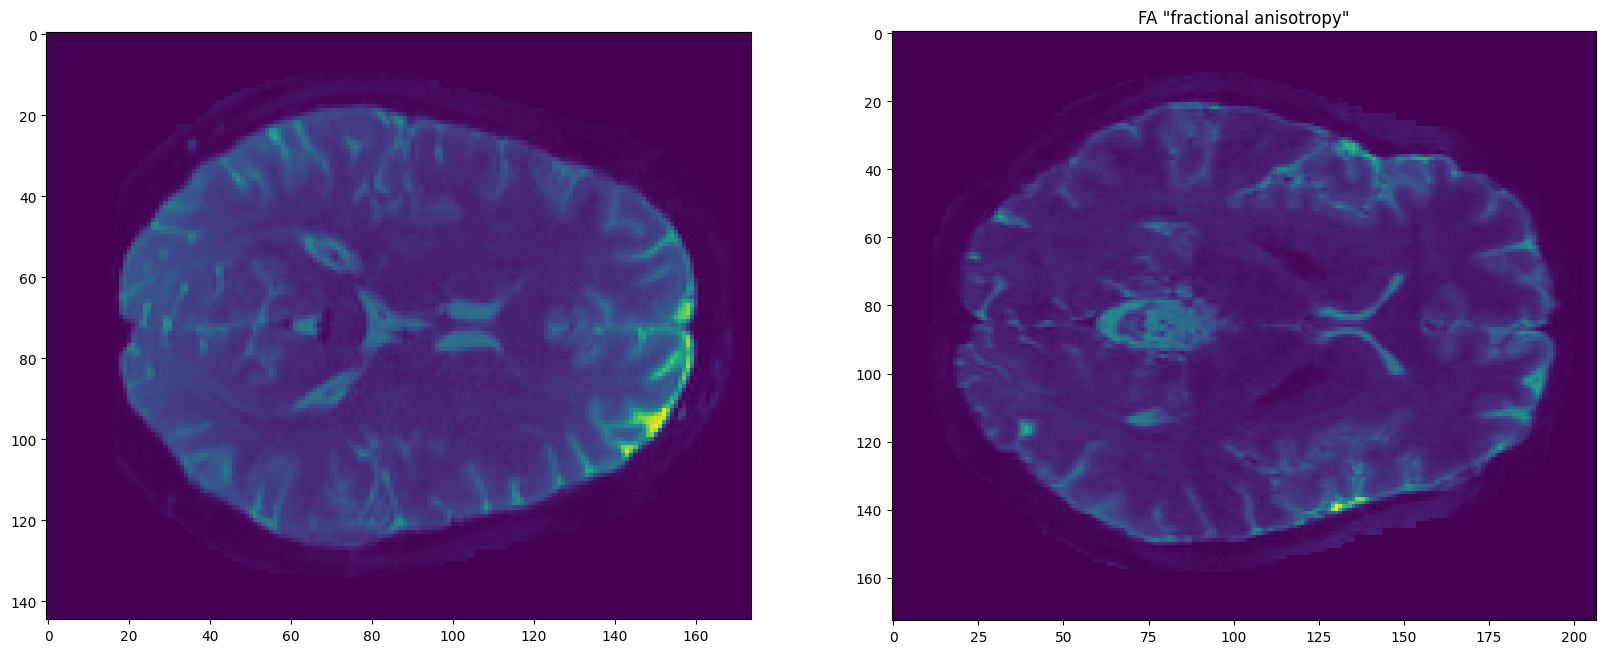

In [26]:
i=70
f, axis = plt.subplots(1, 2)
f.set_figwidth(20)
f.set_figheight(10)
temp = np.transpose(hf_lr.get('mask'), (2,1,0))
# temp = np.fliplr(np.rot90(hf_lr.get('volumes0')[i,:,:,0],k=3))
axis[0].imshow(hf_lr.get('volumes0')[:,:,i,0])
axis[1].set_title('FA "fractional anisotropy"')
axis[1].imshow(np.array(hf.get('volumes0'))[:,:,i,0])
# axis[2].set_title('MD "Mean Diffusivity or Average Diffusion Coefficent(ADC)"')
# axis[2].imshow(np.array(hf.get('ADC'))[:,:,i])
# axis[3].set_title('MD_RGB "Principal Diffusion Directions"')
# axis[3].imshow(np.array(hf.get('color_FA'))[:,:,i])

In [36]:
np.array(hf.get('ADC')).max(),np.array(hf.get('ADC')).min()

(0.08228759206068244, 0.0)

In [37]:
np.array(hf.get('FA')).max(),np.array(hf.get('FA')).min()

(0.9999997058573268, 0.0)

In [38]:
np.array(hf.get('color_FA')).max(),np.array(hf.get('color_FA')).min()

(0.9998092887740151, 0.0)

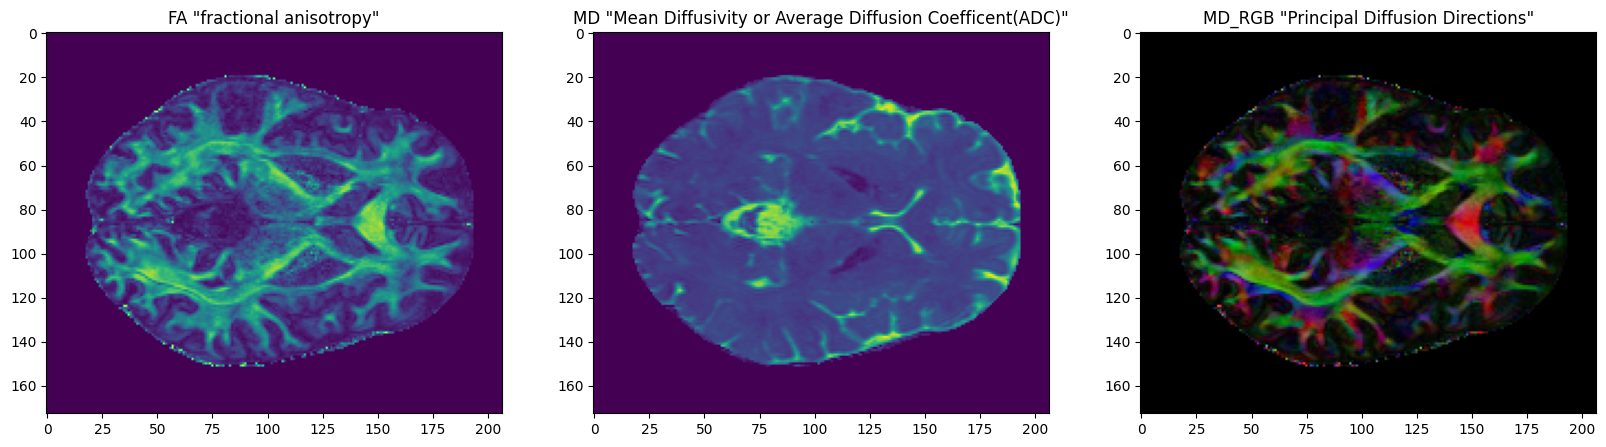

In [44]:
i=70
f, axis = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(10)
axis[0].set_title('FA "fractional anisotropy"')
axis[0].imshow(np.array(hf.get('FA'))[:,:,i])
axis[1].set_title('MD "Mean Diffusivity or Average Diffusion Coefficent(ADC)"')
axis[1].imshow(np.array(hf.get('ADC'))[:,:,i])
axis[2].set_title('MD_RGB "Principal Diffusion Directions"')
axis[2].imshow(np.array(hf.get('color_FA'))[:,:,i])
# plt.colorbar()

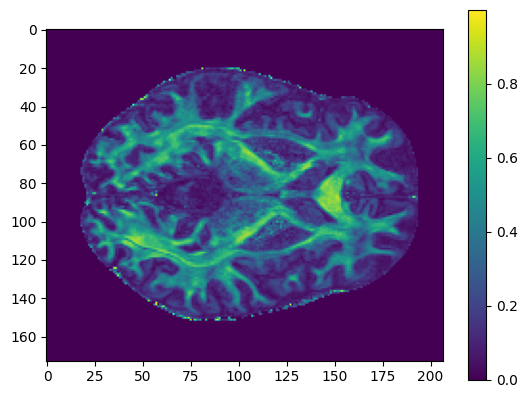

In [46]:
plt.imshow(np.array(hf.get('FA'))[:,:,i])
plt.colorbar()

In [42]:
np.array(hf.get('ADC')).max(),np.array(hf.get('ADC')).min()

(0.08228759206068244, 0.0)